## 本範例需要 ffmpeg 的套件

請務必使用 conda 指令安裝：conda install -c conda-forge ffmpeg

In [1]:
from IPython.display import HTML

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.colors import LogNorm

import autograd.numpy as np
from autograd import grad

## Objective function: the Beale function

In [2]:
beale_func = lambda x, y: (1.5 - x + x * y) ** 2 + (2.25 - x + x * y ** 2) ** 2 + (2.625 - x + x * y ** 3) ** 2
xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2
min_point = np.array([3., .5])
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = beale_func(x, y)

In [3]:
def loss_func(theta):
    return beale_func(*theta)

## Optimizer: Adam

In [4]:
class AdamOptimizer:
    
    def __init__(self, init_theta, loss_func, learning_rate=0.001, beta1=0.9, beta2=0.999, epislon=1e-8):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epislon = epislon
        self.learning_rate = learning_rate
        self.weight_number = len(init_theta)
        self.theta = init_theta
        self.trace = init_theta.reshape((-1, self.weight_number,))
        self.loss_func = loss_func
        self.grad_func = grad(loss_func)
        self.momentum = np.zeros((self.weight_number,))
        self.variance = np.zeros((self.weight_number,))

    def get_next_result(self, epoch):
        if epoch > 0:
            gradient = self.grad_func(self.theta)
            self.momentum = self.get_next_momentum(epoch, gradient)
            self.variance = self.get_next_variance(epoch, gradient)
            self.theta = self.theta - self.learning_rate * self.momentum / (self.variance ** 0.5 + self.epislon)
            self.trace = np.concatenate((self.trace, self.theta.reshape(-1, self.weight_number,),))
        return self.theta, self.loss_func(self.theta)
        
    def get_next_momentum(self, epoch, gradient):
        momentum = self.beta1 * self.momentum + (1 - self.beta1) * gradient
        return momentum
    
    def get_next_variance(self, epoch, gradient):
        variance = self.beta2 * self.variance + (1 - self.beta2) * gradient ** 2
        return variance

def adam_optimizer_iterator(init_theta, loss_func, epochs=30000, show_step=100, tolerance=1e-8, learning_rate=0.001):
    adam_optimizer = AdamOptimizer(init_theta, loss_func, learning_rate=learning_rate)
    for epoch in range(epochs):
        theta, loss = adam_optimizer.get_next_result(epoch)
        if epoch % show_step == 0:
            print('epoch: {}, loss: {:.3f}, weight: {}'.format(epoch, loss, theta))
        if loss < tolerance:
            break
    return adam_optimizer.trace

def adam_optimizer_2dplot(x, y, z, trace):
    fig = plt.figure(figsize=(10, 10,))
    line, = plt.plot([], [], 'r', label='Adam Optimizer', lw=2)
    point, = plt.plot([], [], 'ro')
    plt.contourf(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.terrain)
    plt.plot(*min_point, 'r*', markersize=12)
    plt.xlim((xmin, xmax,))
    plt.ylim((ymin, ymax,))
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend(loc='upper left')
    plt.show()
    return fig, line, point

class AdamOptimizer2DPlayer:
    
    def __init__(self, fig, line, point, trace, frames):
        self.fig = fig
        self.line = line
        self.point = point
        self.trace = trace
        self.frames = frames

    def get_init_topology(self):
        self.line.set_data([], [])
        self.point.set_data([], [])
        return self.line, self.point

    def get_next_topology(self, i):
        self.line.set_data(*self.trace[:, :i])
        self.point.set_data(*self.trace[:, i - 1:i])
        return self.line, self.point
    
    def make_html_display(self):
        anim = animation.FuncAnimation(self.fig, self.get_next_topology, init_func=self.get_init_topology,
                                       frames=self.frames, interval=60, repeat_delay=5, blit=True)
        return HTML(anim.to_html5_video())

def adam_optimizer_2dplay(fig, line, point, trace):
    player = AdamOptimizer2DPlayer(fig, line, point, trace, trace.shape[1])
    return player.make_html_display()

In [5]:
show_step = 100
adam_trace = adam_optimizer_iterator(np.array([1., 1.5]), loss_func, show_step=show_step)

epoch: 0, loss: 41.250, weight: [1.  1.5]
epoch: 100, loss: 17.221, weight: [0.67415385 1.13866242]
epoch: 200, loss: 14.171, weight: [0.62230955 0.99811097]
epoch: 300, loss: 12.511, weight: [0.64762504 0.89496257]
epoch: 400, loss: 11.034, weight: [0.720799   0.80511903]
epoch: 500, loss: 9.510, weight: [0.82491596 0.72195248]
epoch: 600, loss: 7.968, weight: [0.94535576 0.64422548]
epoch: 700, loss: 6.509, weight: [1.07064624 0.57251791]
epoch: 800, loss: 5.214, weight: [1.19334812 0.50759576]
epoch: 900, loss: 4.120, weight: [1.30943034 0.4498415 ]
epoch: 1000, loss: 3.227, weight: [1.41709675 0.39922999]
epoch: 1100, loss: 2.516, weight: [1.51581307 0.35547054]
epoch: 1200, loss: 1.962, weight: [1.60569233 0.31814165]
epoch: 1300, loss: 1.536, weight: [1.68715511 0.28677686]
epoch: 1400, loss: 1.212, weight: [1.76075591 0.26090837]
epoch: 1500, loss: 0.969, weight: [1.8271     0.24008413]
epoch: 1600, loss: 0.787, weight: [1.88680615 0.22387081]
epoch: 1700, loss: 0.652, weight: [

In [6]:
adam_trace, length = adam_trace.T, adam_trace.shape[0]
if length > show_step:
    adam_trace = adam_trace[:, ::show_step]
adam_trace

array([[1.        , 0.67415385, 0.62230955, 0.64762504, 0.720799  ,
        0.82491596, 0.94535576, 1.07064624, 1.19334812, 1.30943034,
        1.41709675, 1.51581307, 1.60569233, 1.68715511, 1.76075591,
        1.8271    , 1.88680615, 1.94049112, 1.98876332, 2.03221907,
        2.07143878, 2.10698186, 2.13938053, 2.16913288, 2.19669621,
        2.22248115, 2.24684731, 2.27010095, 2.29249478, 2.31422995,
        2.33545997, 2.35629622, 2.37681449, 2.39706188, 2.41706369,
        2.43682959, 2.45635893, 2.47564484, 2.49467725, 2.51344494,
        2.53193673, 2.5501421 , 2.56805145, 2.58565612, 2.6029483 ,
        2.61992093, 2.63656755, 2.6528822 , 2.66885928, 2.68449352,
        2.69977983, 2.71471334, 2.72928925, 2.74350288, 2.75734961,
        2.77082484, 2.78392405, 2.79664273, 2.80897646, 2.82092088,
        2.83247173, 2.84362492, 2.85437652, 2.86472284, 2.87466051,
        2.8841865 , 2.89329822, 2.9019936 , 2.91027116, 2.91813012,
        2.92557048, 2.93259311, 2.93919987, 2.94

## Visualize convergence trace

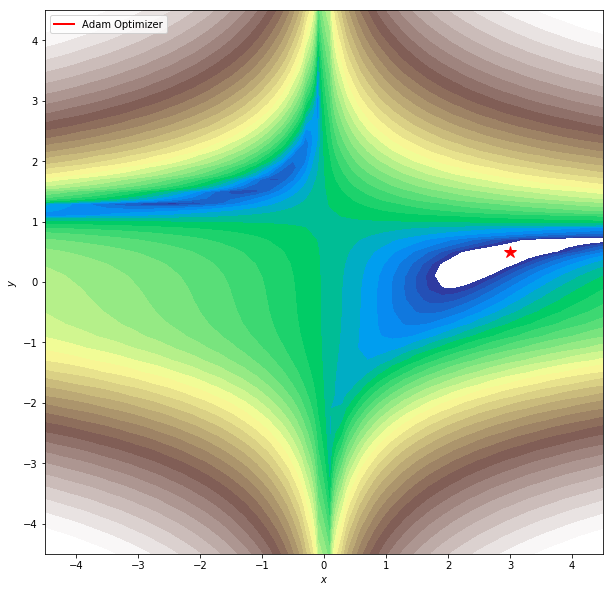

In [7]:
fig, line, point = adam_optimizer_2dplot(x, y, z, adam_trace)

In [8]:
html = adam_optimizer_2dplay(fig, line, point, adam_trace)
html